In [ ]:
# =======================================
#               CONFIGURATION
# =======================================
eval_mode = True

In [ ]:
# =======================================
#               IMPORTS
# =======================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict
import os
import joblib

# =======================================
#               CONSTANTS
# =======================================
OOD_LABEL = 10
TOTAL_NUM_MNIST_CLASSES = 10
THRESHOLD_PRECENTILE = 99
RANDOM_STATE = 42
PAIRWISE_METRIC = 'cosine'
BASE_MODEL_WEIGHTS_FILE_PATH = "./baseline_model.pth"
NUM_OF_EPOCHS = 5
Learning_Rate = 0.001
MNIST_TRAIN_SIZE = 50000
MNIST_TEST_SIZE = 10000
OOD_SAMPLE_SIZE = 2000
BATCH_SIZE = 1024

DATA_ROOT_DIRECTORY = './data'

### Combined Dataset for Normal and OOD Samples

This class, `CombinedDataset`, merges the MNIST dataset (known classes) with an out-of-distribution (OOD) dataset. It enables the model to distinguish between normal samples and unknown samples during evaluation.

- **Initialization (`__init__`)**:
  - Accepts MNIST and OOD datasets as inputs.
  - Allows separate transformations for MNIST (`transform_mnist`) and OOD (`transform_ood`) samples.
  
- **Length (`__len__`)**:
  - Returns the total number of samples, including both MNIST and OOD datasets.

- **Fetching Data (`__getitem__`)**:
  - If the index falls within the MNIST dataset, it retrieves the corresponding image and label, applying transformations if provided.
  - If the index corresponds to the OOD dataset, it fetches the sample, applies transformations if provided, and assigns a predefined OOD label.

This dataset is used to evaluate Open Set Recognition (OSR) performance by testing the model's ability to classify MNIST digits correctly while flagging unseen classes as "Unknown."


In [ ]:
class CombinedDataset(Dataset):
    """ Combines MNIST dataset with OOD dataset and assigns label to OOD samples """
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            data, _ = self.ood[idx - len(self.mnist)]
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, OOD_LABEL  # Assign OOD label

def get_osr_dataset(dataset=None):
    """
    Returns a TensorDataset for the OSR dataset.
    Ensures transformations are applied before converting to tensors.
    """
    if dataset is not None:
        transform_ood = transforms.Compose([transforms.ToPILImage(),transforms.Grayscale(num_output_channels=1), transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
        # Apply transformations to each image in dataset
        data = torch.stack([transform_ood(img) for img in dataset.data])  # Apply transform_ood
        labels = torch.tensor(dataset.targets)  # Convert labels to tensor
    else:
        # Create empty tensors if no dataset is provided
        data = torch.empty(0, 1, 28, 28)  # Adjusted shape
        labels = torch.empty(0, dtype=torch.long)

    return TensorDataset(data, labels)


### Base Model: Autoencoder with Classification

This section defines the **Base Autoencoder Model**, which performs both feature extraction and classification on the MNIST dataset. It also includes training functions for optimizing the model.

#### **BaseAutoencoder Class**
This class implements a convolutional **autoencoder** that serves two purposes:
1. **Reconstruct input images** to learn meaningful representations.
2. **Classify images** into the 10 MNIST digit classes.

#### **Model Architecture**
- **Encoder:**
  - Uses three convolutional layers with ReLU activations to extract features.
  - Flattens the extracted features and reduces dimensionality through fully connected layers.
- **Decoder:**
  - Uses transposed convolutional layers to reconstruct images from the encoded feature space.
- **Classifier:**
  - A fully connected layer that maps the encoded representation to classification logits (10 MNIST classes).

#### **Forward Pass**
- The model returns three outputs:
  1. `recon` - The reconstructed image.
  2. `class_logits` - Predicted class logits for MNIST classification.
  3. `embeddings` - Feature representation learned by the encoder.

---

### Base Model Training Functions

#### **plot_training(train_losses)**
- Plots the training loss over epochs to visualize model convergence.
- Uses Matplotlib to generate a line chart showing the progression of the loss function.

#### **train_base_model(model, train_loader, device, epochs=NUM_OF_EPOCHS)**
- Trains the autoencoder model on the MNIST dataset.
- **Workflow:**
  1. Moves the model to the specified device (CPU/GPU).
  2. Uses **Adam optimizer** with a predefined learning rate.
  3. Uses **CrossEntropyLoss** for classification and **MSELoss** for reconstruction.
  4. Iterates through the training data, computes both losses, and updates model weights.
  5. Logs training progress and execution time per epoch.
  6. Saves the trained model to `BASE_MODEL_WEIGHTS_FILE_PATH`.
  7. Calls `plot_training()` to visualize the loss curve.

This autoencoder is essential for feature extraction, which will later be used to improve Open Set Recognition (OSR) capabilities.


In [ ]:
class BaseAutoencoder(nn.Module):
    """ Autoencoder for MNIST classification and feature extraction """
    def __init__(self, latent_dim=128):
        super(BaseAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, TOTAL_NUM_MNIST_CLASSES)  # Output 10 classes (0-9)
        )

    def forward(self, x):
        embeddings = self.encoder(x)
        recon = self.decoder(embeddings)
        class_logits = self.classifier(embeddings)
        return recon, class_logits, embeddings

# ========================================================
#           Base Model Training Functions
# ========================================================
def plot_training(train_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='blue', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xticks(range(1, len(train_losses) + 1))
    plt.legend(["Train Loss"])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def train_base_model(model, train_loader, device, epochs=NUM_OF_EPOCHS):
    """ Trains the base autoencoder model on MNIST """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=Learning_Rate)
    criterion_class = nn.CrossEntropyLoss()
    criterion_recon = nn.MSELoss()
    train_losses = []
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            recon, class_logits, _ = model(images)

            loss_recon = criterion_recon(recon, images)
            loss_class = criterion_class(class_logits, labels)
            loss = loss_recon + loss_class

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[Epoch {epoch+1}/{epochs}]: Loss: {total_loss/len(train_loader):.4f} [{time.time() - epoch_start_time:.2f} s]")
        train_losses.append(total_loss/len(train_loader))

    elapsed_time = time.time() - start_time
    print(f"Total Training Time: {int(elapsed_time // 60)} Mintues and {int(elapsed_time % 60)} Seconds")
    torch.save(model.state_dict(), BASE_MODEL_WEIGHTS_FILE_PATH)
    plot_training(train_losses)

### OSR Model Wrapper for OOD Detection

This class, `OSRModel`, extends the base autoencoder model to perform **Open Set Recognition (OSR)** by detecting out-of-distribution (OOD) samples. It leverages **K-Means clustering** and **Mean Squared Error (MSE) reconstruction loss** to determine whether a sample belongs to a known class or is an unseen class.

#### **Initialization (`__init__`)**
- **Inputs:**
  - `base_model`: The trained autoencoder model.
  - `train_loader`: Data loader containing MNIST training samples.
  - `device`: The computing device (CPU/GPU).
  - `threshold_percentile`: Defines the percentile cutoff for identifying OOD samples.

- **Key Steps:**
  1. **Extract embeddings** from MNIST training data using the encoder.
  2. **Train K-Means clustering** on MNIST embeddings to form `TOTAL_NUM_MNIST_CLASSES` clusters (0-9 digits).
  3. **Compute distance thresholds** per cluster for identifying OOD samples.
  4. **Compute MSE threshold** for detecting images that have poor reconstruction quality.

---

### **Helper Functions**

#### **get_embeddings(data_loader)**
- Extracts the **latent feature vectors** (embeddings) from the base model for each input image.
- Used to train the **K-Means clustering model**.

#### **compute_cluster_thresholds(embeddings, threshold_percentile)**
- Computes **distance-based thresholds** for each K-Means cluster.
- For each cluster, it determines the **percentile distance cutoff**, beyond which a sample is considered OOD.

#### **compute_mse(images)**
- Computes the **Mean Squared Error (MSE)** between an image and its autoencoder reconstruction.
- High reconstruction error may indicate that the image does not belong to the known dataset.

---

### **Forward Pass (`forward`)**
- **Classification Predictions**:
  - Uses the base model's classifier to predict MNIST digit labels.
- **Cluster Distance Calculation**:
  - Measures how close an image's embedding is to its nearest K-Means cluster center.
- **OOD Detection Logic**:
  - Samples exceeding **either** the **cluster distance threshold** or the **MSE threshold** are labeled as "Unknown".
- **Final Decision**:
  - If a sample is deemed OOD, it is assigned the `OOD_LABEL`.

This OSR model ensures robust classification while detecting unseen samples using **feature clustering** and **reconstruction loss**, making it effective for real-world Open Set Recognition (OSR) tasks.


In [ ]:
class OSRModel(nn.Module):
    """ Wrapper for Base Model with OOD Detection using K-Means """
    def __init__(self, base_model, train_loader, device, threshold_percentile=THRESHOLD_PRECENTILE, save_path="kmeans_model.pkl"):
        super(OSRModel, self).__init__()
        self.base_model = base_model.to(device)
        self.device = device
        self.num_clusters = TOTAL_NUM_MNIST_CLASSES
        self.kmeans_save_path = save_path  # Path to save/load K-Means model

        # Step 1: Extract embeddings from MNIST training data
        mnist_embeddings, mnist_labels = self.get_embeddings(train_loader)

        # Step 2: Train or Load K-Means clustering
        if eval_mode and os.path.exists(self.kmeans_save_path):
            print(f"🔹 Loading K-Means model from {self.kmeans_save_path}")
            self.kmeans = joblib.load(self.kmeans_save_path)
        else:
            print("🔹 Training new K-Means model..." if not eval_mode else "⚠️ K-Means model not found, training a new one...")
            self.kmeans = KMeans(n_clusters=self.num_clusters, random_state=RANDOM_STATE)
            self.kmeans.fit(mnist_embeddings)
            joblib.dump(self.kmeans, self.kmeans_save_path)  # Save trained model

        # Step 3: Compute threshold for detecting OOD samples
        self.cluster_thresholds = self.compute_cluster_thresholds(mnist_embeddings, threshold_percentile)

        # Step 4: Compute MSE threshold for OOD detection
        mse_id = np.array([self.compute_mse(img)[0] for img, _ in train_loader])
        self.mse_threshold = np.percentile(mse_id, threshold_percentile)




    def get_embeddings(self, data_loader):
        """ Extracts latent embeddings for training K-Means clustering """
        self.base_model.eval()
        embeddings, labels = [], []
        with torch.no_grad():
            for images, targets in data_loader:
                images = images.to(self.device)
                _, _, latent_vectors = self.base_model(images)
                embeddings.append(latent_vectors.cpu())
                labels.append(targets.cpu())

        embeddings = torch.cat(embeddings, dim=0).numpy()
        labels = torch.cat(labels, dim=0).numpy()
        return embeddings, labels

    def compute_cluster_thresholds(self, embeddings, threshold_percentile):
        """ Compute per-cluster distance thresholds """
        distances = pairwise_distances(embeddings, self.kmeans.cluster_centers_, metric=PAIRWISE_METRIC)
        cluster_assignments = self.kmeans.predict(embeddings)

        # Compute threshold per cluster
        thresholds = {}
        for cluster_idx in range(self.num_clusters):
            cluster_distances = distances[np.where(cluster_assignments == cluster_idx), cluster_idx]
            thresholds[cluster_idx] = np.percentile(cluster_distances, threshold_percentile)

        return thresholds  # Dictionary of per-cluster thresholds

    def compute_mse(self, images):
      """ Compute reconstruction error in pixel space """
      images = images.to(self.device)

      with torch.no_grad():  # Ensure no gradients are tracked
          reconstructions, _, _ = self.base_model(images)
          mse = F.mse_loss(reconstructions, images, reduction='none')
          mse = mse.view(mse.shape[0], -1).mean(dim=1)  # Mean per-image MSE

      return mse.detach().cpu().numpy().flatten()


    def forward(self, images):
        """ Performs classification and OOD detection using both K-Means and MSE """
        self.base_model.eval()
        images = images.to(self.device)

        with torch.no_grad():
            _, logits, embeddings = self.base_model(images)

        # Classification predictions
        classifier_preds = logits.argmax(dim=1)

        # Compute distance to nearest cluster
        distances = pairwise_distances(embeddings, self.kmeans.cluster_centers_, metric=PAIRWISE_METRIC)
        nearest_clusters = distances.argmin(axis=1)
        nearest_cluster_dists = distances[np.arange(len(distances)), nearest_clusters]

        # Compute MSE reconstruction error
        mse_errors = self.compute_mse(images)

        # OOD decision: samples exceeding either distance or MSE threshold
        is_ood = np.array([
            (nearest_cluster_dists[i] > self.cluster_thresholds[nearest_clusters[i]]) or
            (mse_errors[i] > self.mse_threshold)
            for i in range(len(nearest_clusters))
        ])

        classifier_preds[is_ood] = OOD_LABEL  # Mark OOD samples

        return classifier_preds


### Evaluation Functions

This section provides functions to evaluate both the **baseline classification model** (on MNIST) and the **Open Set Recognition (OSR) model** (on MNIST and OOD samples). The evaluation measures classification accuracy and the model's ability to distinguish between known and unknown samples.

---

### **1️⃣ MNIST Baseline Evaluation (`eval_mnist_baseline`)**
- **Purpose:** Computes the accuracy of the base model on the MNIST test set.
- **Workflow:**
  1. Sets the model to evaluation mode (`model.eval()`).
  2. Iterates over the test dataset and predicts class labels.
  3. Computes the accuracy as the ratio of correctly classified samples.
  4. Returns the true labels and predicted labels for further analysis.

- **Output:**
  - Prints MNIST classification accuracy.
  - Returns numpy arrays of true and predicted labels.

---

### **2️⃣ OSR Model Evaluation (`eval_osr_model`)**
- **Purpose:** Evaluates the OSR model's classification performance on both MNIST and OOD samples.
- **Workflow:**
  1. Extracts latent embeddings using the base model.
  2. Uses the OSR model to classify each input.
  3. Separates MNIST and OOD samples:
     - `mask_mnist`: Identifies known MNIST samples.
     - `mask_ood`: Identifies OOD samples.
  4. Computes accuracy separately for:
     - MNIST digits (0-9).
     - OOD samples (should be classified as "Unknown").
     - Overall accuracy.
  5. Prints classification accuracy for MNIST, OOD, and total accuracy.
  6. Returns embeddings, true labels, and predicted labels for further analysis.

- **Output:**
  - Accuracy score


In [ ]:
def eval_mnist_baseline(model, data_loader, device):
    """ Computes baseline accuracy on the MNIST test set. """
    model.eval()
    correct = 0
    total = 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            _, outputs, _ = model(images)  # Get classifier output
            predicted = outputs.argmax(dim=1)  # Choose highest probability

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print("################################################")
    print(f'MNIST Baseline Accuracy: {accuracy * 100:.2f}%')
    print("################################################")
    return np.array(true_labels), np.array(pred_labels)


def eval_osr_model(osr_model, data_loader):
    """ Evaluates OSR model for both MNIST and OOD samples """
    osr_model.eval()
    correct_mnist, total_mnist = 0, 0
    correct_ood, total_ood = 0, 0
    embeddings, true_labels, pred_labels =[], [], []


    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(osr_model.device), labels.to(osr_model.device)
            _, _, latent_vectors = osr_model.base_model(images)  # Extract embeddings

            predictions = osr_model(images)

            embeddings.append(latent_vectors.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

            mask_mnist = labels < OOD_LABEL
            mask_ood = ~mask_mnist

            correct_mnist += (predictions[mask_mnist] == labels[mask_mnist]).sum().item()
            total_mnist += mask_mnist.sum().item()

            correct_ood += (predictions[mask_ood] == OOD_LABEL).sum().item()
            total_ood += mask_ood.sum().item()


    acc_mnist = correct_mnist / total_mnist if total_mnist > 0 else 0
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    print(f"OSR Model Accuracy (MNIST): {acc_mnist * 100:.2f}%")
    print(f"OSR Model Accuracy (OOD): {acc_ood * 100:.2f}%")
    print(f"Total Accuracy: {acc_total * 100:.2f}%")

    return np.concatenate(embeddings, axis=0), np.array(true_labels), np.array(pred_labels)


def eval_osr_binary(osr_model, data_loader):
    """ Evaluates OSR model as a binary classifier (Known vs. Unknown). """
    osr_model.base_model.eval()
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(osr_model.device), labels.to(osr_model.device)
            predictions = osr_model(images)  # Get predictions

            # Convert labels: 0-9 (MNIST) → Known (0), OOD → Unknown (1)
            for i in range(len(labels)):
                if labels[i] != OOD_LABEL:
                    labels[i] = 0
                else:
                    labels[i] = 1
            for i in range(len(predictions)):
                if predictions[i] != OOD_LABEL:
                    predictions[i] = 0
                else:
                    predictions[i] = 1

            # Store results
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predictions.cpu().numpy())

    return np.array(true_labels), np.array(pred_labels)


### Main Execution: Load Data

This section initializes the datasets, applies necessary transformations, and creates **data loaders** for training and evaluation.

---

### **1️⃣ Selecting the OOD Dataset**
- Checks if the specified `OOD_DATASET` exists in `OOD_DATASET_OPTIONS`.
- Raises an error if an invalid dataset name is provided.

---

### **2️⃣ Device Selection**
- Sets the computing device to **GPU** if available; otherwise, defaults to **CPU**.

---

### **3️⃣ Compute Mean and Standard Deviation (`compute_mean_std`)**
- Computes the **mean** and **standard deviation** of the MNIST dataset.
- Used for **normalization** to ensure consistent input distribution.

---

### **4️⃣ Define Data Transformations**
- **MNIST Transformations**:
  - Converts images to tensors.
  - Normalizes pixel values using computed mean and standard deviation.
- **OOD Transformations**:
  - Converts images to **grayscale** (to match MNIST).
  - Resizes to **28x28 pixels** (to match MNIST dimensions).
  - Applies the same normalization as MNIST.

---

### **5️⃣ Load Datasets**
- **MNIST Dataset**:
  - Downloads and applies transformations.
- **OOD Dataset (FashionMNIST)**:
  - Used as out-of-distribution (OOD) data.
  - Transformed using MNIST normalization.

---

### **6️⃣ Train-Test Split**
- Splits the MNIST dataset into **training** (`mnist_train`) and **test** (`mnist_test`) sets.
- Extracts a subset of OOD samples (`ood_subset`) for evaluation.

---

### **7️⃣ Create Data Loaders**
- **`train_loader`**: Loads **MNIST training data** for model training.
- **`test_loader`**: Loads **MNIST test data** for baseline evaluation.
- **`combined_loader`**: Loads **both MNIST and OOD samples**, enabling OSR evaluation.

These data loaders facilitate efficient **batch processing** during training and evaluation.


In [ ]:
# ========================================================
#           Main Execution: Load Data
# ========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    data = next(iter(loader))[0]  # Extract images (ignore labels)
    mean = data.mean().item()
    std = data.std().item()

    return mean, std

mnist_raw = datasets.MNIST(root=DATA_ROOT_DIRECTORY, train=True, transform=transforms.ToTensor(), download=True)
mean, std = compute_mean_std(mnist_raw)

# Data transforms
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
transform_ood = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

# Load datasets
mnist_full = datasets.MNIST(root=DATA_ROOT_DIRECTORY, train=True, download=True, transform=transform_mnist)
ood_dataset = datasets.FashionMNIST(root=DATA_ROOT_DIRECTORY, train=False, download=True, transform=transform_ood)

# Train-test split
mnist_train, mnist_test = random_split(mnist_full, [MNIST_TRAIN_SIZE, MNIST_TEST_SIZE])
ood_subset, _ = random_split(ood_dataset, [OOD_SAMPLE_SIZE, len(ood_dataset) - OOD_SAMPLE_SIZE])

# Create data loaders
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)
combined_loader = DataLoader(CombinedDataset(mnist_test, ood_subset), batch_size=BATCH_SIZE, shuffle=True)

###### Training base model ######
[Epoch 1/5]: Loss: 1.3933 [38.45 s]
[Epoch 2/5]: Loss: 0.5633 [37.76 s]
[Epoch 3/5]: Loss: 0.3804 [38.64 s]
[Epoch 4/5]: Loss: 0.2938 [39.27 s]
[Epoch 5/5]: Loss: 0.2431 [37.79 s]
Total Training Time: 3 Mintues and 11 Seconds


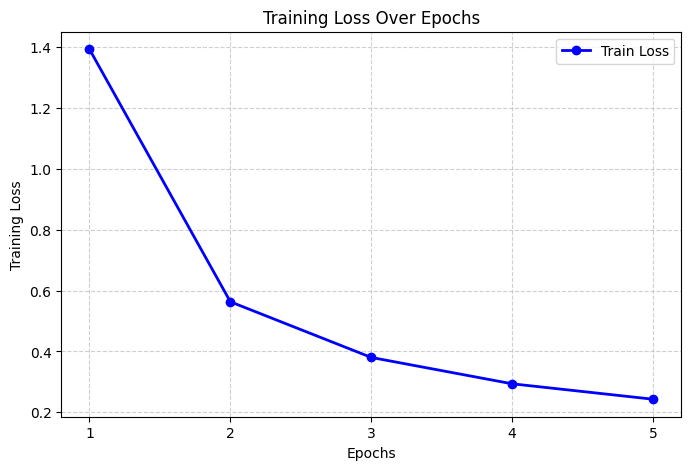

################################################
MNIST Baseline Accuracy: 98.34%
################################################


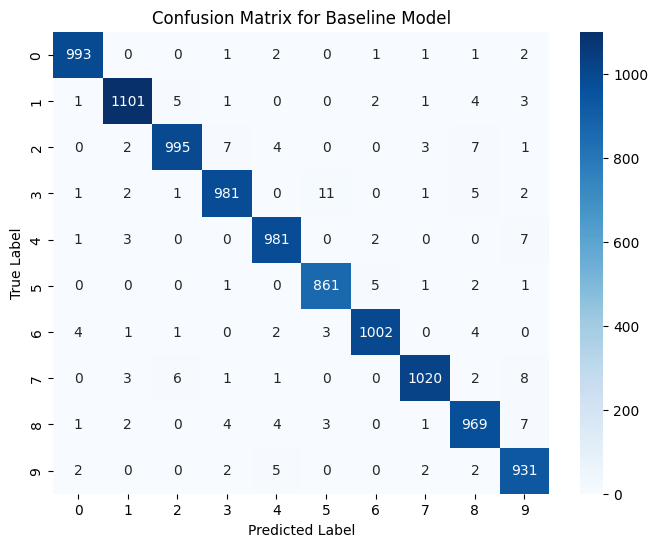

In [ ]:
# ========================================================
#           Main Execution: Train
# ========================================================
base_model = BaseAutoencoder()
if not eval_mode:
    print("###### Training base model ######")
    train_base_model(base_model, train_loader, device)
else:
    print("$> Skipping training.\nLoading pre-trained model weights...")
    base_model.load_state_dict(torch.load(BASE_MODEL_WEIGHTS_FILE_PATH, map_location=device))

# ========================================================
#       Main Execution: Base Model Evaluate & Plot
# ========================================================
true_labels, pred_labels = eval_mnist_baseline(base_model, test_loader, device)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(TOTAL_NUM_MNIST_CLASSES), yticklabels=range(TOTAL_NUM_MNIST_CLASSES))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Baseline Model")
plt.show()

🔹 Training new K-Means model...


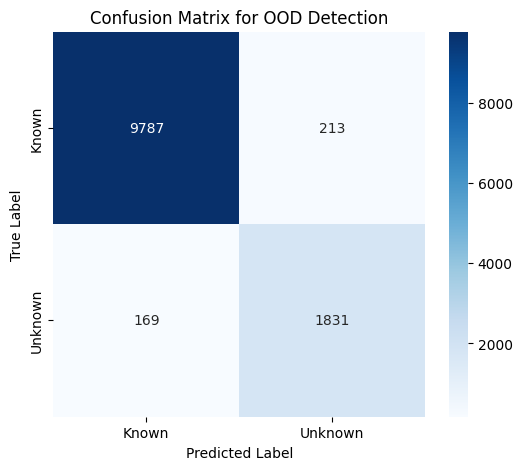

In [ ]:
# ========================================================
#       Main Execution: OSR Model Binary Evaluate & Plot
# ========================================================
osr_model = OSRModel(base_model, train_loader, device)
true_binary, pred_binary = eval_osr_binary(osr_model, combined_loader)
cm = confusion_matrix(true_binary, pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Known", "Unknown"], yticklabels=["Known", "Unknown"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for OOD Detection")
plt.show()

OSR Model Accuracy (MNIST): 96.50%
OSR Model Accuracy (OOD): 91.55%
Total Accuracy: 95.67%


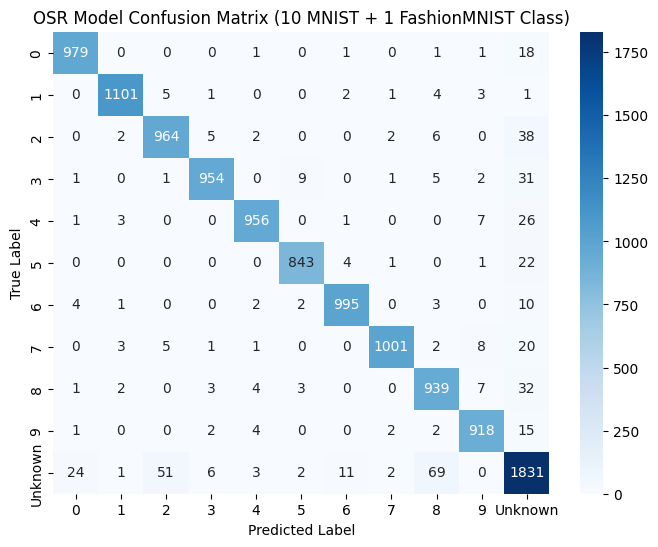

In [ ]:
# ========================================================
#       Main Execution: OSR Model Binary Evaluate & Plot
# ========================================================
embeddings, true_labels, pred_labels = eval_osr_model(osr_model, combined_loader)
cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(TOTAL_NUM_MNIST_CLASSES + 1))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(TOTAL_NUM_MNIST_CLASSES)) + ["Unknown"], yticklabels=list(range(TOTAL_NUM_MNIST_CLASSES)) + ["Unknown"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"OSR Model Confusion Matrix ({TOTAL_NUM_MNIST_CLASSES} MNIST + 1 {type(ood_dataset).__name__} Class)")
plt.show()

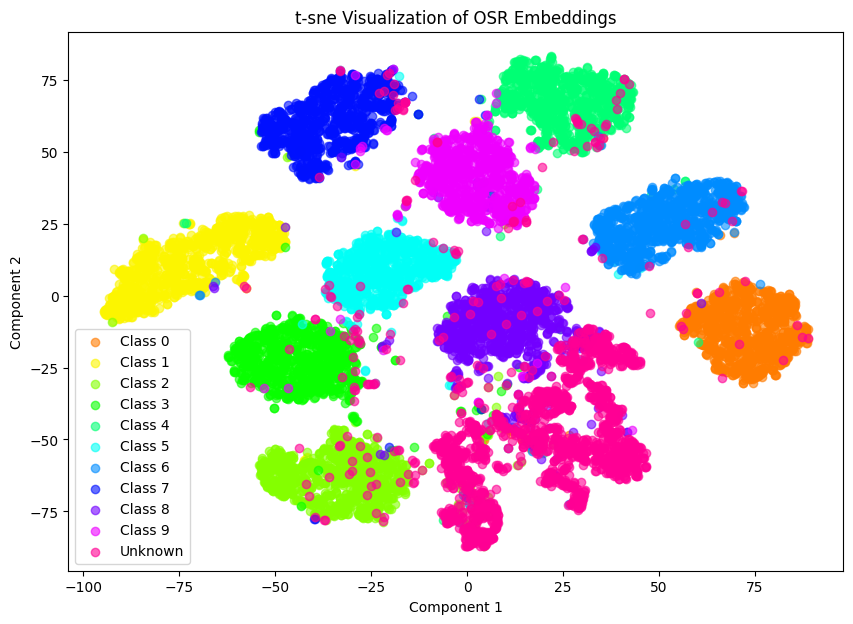

In [ ]:
# ========================================================
#               Main Execution: TSNE
# ========================================================
reducer = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings = reducer.fit_transform(embeddings)

# Define colors for 11 classes (10 MNIST + 1 OOD)
colors = sns.color_palette("hsv", TOTAL_NUM_MNIST_CLASSES + 1)

# Plot the results
plt.figure(figsize=(10, 7))
for i in range(TOTAL_NUM_MNIST_CLASSES + 1):  # 0-9 (digits) + 10 (OOD)
    plt.scatter(
        reduced_embeddings[pred_labels == i, 0],
        reduced_embeddings[pred_labels == i, 1],
        color=colors[i],
        label=f"Class {i}" if i != OOD_LABEL else "Unknown",
        alpha=0.6
    )

plt.legend()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-sne Visualization of OSR Embeddings")
plt.show()

🔹 Training new K-Means model...


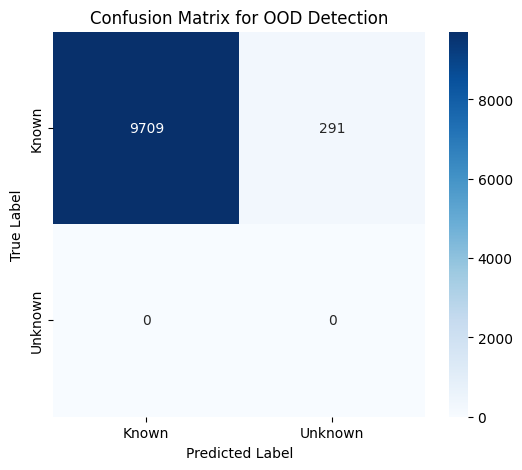

In [ ]:
# ========================================================
#       Main Execution: OSR Model Place Holder Binary Evaluate & Plot
# ========================================================
osr_model = OSRModel(base_model, train_loader, device)
osr_dataset = get_osr_dataset()
osr_subset, _ = random_split(osr_dataset, [OOD_SAMPLE_SIZE, len(osr_dataset) - OOD_SAMPLE_SIZE])
combined_loader_place_holder = DataLoader(CombinedDataset(mnist_test, osr_subset), batch_size=1024, shuffle=True)
true_binary, pred_binary = eval_osr_binary(osr_model, combined_loader_place_holder)
cm = confusion_matrix(true_binary, pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Known", "Unknown"], yticklabels=["Known", "Unknown"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for OOD Detection")
plt.show()

OSR Model Accuracy (MNIST): 95.88%
OSR Model Accuracy (OOD): 0.00%
Total Accuracy: 95.88%


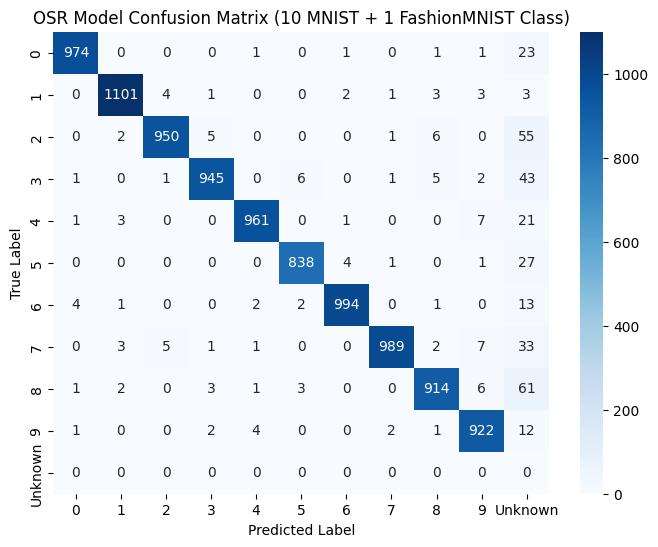

In [ ]:
# ========================================================
#       Main Execution: OSR Model Place Holder Binary Evaluate & Plot
# ========================================================
embeddings, true_labels, pred_labels = eval_osr_model(osr_model, combined_loader_place_holder)
cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(TOTAL_NUM_MNIST_CLASSES + 1))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(TOTAL_NUM_MNIST_CLASSES)) + ["Unknown"], yticklabels=list(range(TOTAL_NUM_MNIST_CLASSES)) + ["Unknown"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"OSR Model Confusion Matrix ({TOTAL_NUM_MNIST_CLASSES} MNIST + 1 {type(ood_dataset).__name__} Class)")
plt.show()